# 2D Gaussian splatting from scratch with tinygrad

This is an introduction to Gaussian splatting from scratch. We are going to start from the basics about the Gaussians, creation of the image till the training of it.
This material's purpose is teaching firstly to myself and then to the community. I am a neewby myself so any suggestions or corrections are very welcome!



In [2]:
!python -m pip install git+https://github.com/tinygrad/tinygrad.git
!python -m pip install matplotlib
!python -m pip install pyyaml

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/tinygrad/tinygrad.git to /private/var/folders/s1/yjdn57xx1h722cf3l8c3h7qc0000gn/T/pip-req-build-8kzly9uf
  Running command git clone --filter=blob:none --quiet https://github.com/tinygrad/tinygrad.git /private/var/folders/s1/yjdn57xx1h722cf3l8c3h7qc0000gn/T/pip-req-build-8kzly9uf
  Resolved https://github.com/tinygrad/tinygrad.git to commit 494b20e88654f154be3391f465241c962e20ed56
  Installing build dependencies ... -^C
anceled
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [23]:
# first let's import the necessary libraries
import numpy as np # numpy is the main library we will use for numerical computations
import matplotlib.pyplot as plt # matplotlib is the main library we will use for plotting

# the only two libraries we will need.
from tinygrad import Tensor, dtypes # Autograd library
from tinygrad.nn.optim import Adam
from tinygrad import TinyJit

In the following I will explain step by step the code and have examples of output and explaining such outputs step by step!

In [24]:
img_size = (256,256,3) # size of the image

# first we will define 3 example of Gaussians with their properties
kernel_size = 105 # dimension of the kernel -> it is the quality of the Gaussian
scale_x = Tensor([1.0,0.5,1.0]) # scale of the Gaussian in x direction
scale_y = Tensor([1.0,1.5,0.5]) # scale of the Gaussian in y direction

# we need to add a regularization to the scale to get the correct scale when generating an image
# the kernel defines the how big the gaussian is going to be. 
# Depending on the kernel size, the scale of the Gaussian needs to be adjusted to be consistent among images
# this took me quite some time to figure it out, but it is important to have the correct scale for the Gaussian
scale_x = scale_x / (img_size[0] / kernel_size)
scale_y = scale_y / (img_size[1] / kernel_size)

scale = scale_x.stack(scale_y, dim=1) # stack the two scales together

rotation = Tensor([0.0, np.pi/4, -(np.pi/2)]) # rotation of the Gaussian in radians
coordinates = Tensor([(0,0), (5,5), (-0.5, -0.5)]) # coordinates of the Gaussian
colors = Tensor([(1,0,0), (1,0,0), (0,0,1)]) # color of the Gaussian
img_size = (105,105,3) # size of the image
W = img_size[0] # width of the image
H = img_size[1] # height of the image

after defining all these variables that hopefully makes sense to you, we will use said variables to display an image containing the Gaussians defined with these variables.
We need to remember that we always want all these process to be differentiable so to have the created image compared to a loss and back-propagate the error.

## Generate splat function

This function takes as input the above variables and returns an image.

In [25]:
batch_size = colors.shape[0] # number of Gaussians defined above

# check that everything has the correct shape
scale = scale.reshape(batch_size, 2)
rotation = rotation.reshape(batch_size)

Now from the data we need to create the covariance matrix that defines the Gaussian. This way we can obtain a differentiable function for splatting the Gaussian. For more informations please get familiar with the math at the following link [here](https://arxiv.org/pdf/2312.02121).

In [26]:
import math
np.cos([0.0, np.pi/4, -1.5707964])

array([ 1.00000000e+00,  7.07106781e-01, -7.32051035e-08])

In [27]:
# create the rotation matrix R
cos_rot = rotation.cos()
sin_rot = rotation.sin()

top = cos_rot.stack(-sin_rot, dim=1)
bottom = sin_rot.stack(cos_rot, dim=1)
R = top.stack(bottom, dim=2).reshape(batch_size, 2, 2)

print("R", R.numpy())
print("==" * 10)

# create the scale matrix S
S = Tensor.eye(2).unsqueeze(0) * scale.unsqueeze(1)
print("S", S.numpy())
print("==" * 10)

covariance = R @ S @ S @ R.transpose(-1,-2)
print("covariance", covariance.numpy())
print("==" * 10)

R [[[ 1.000000e+00  0.000000e+00]
  [-0.000000e+00  1.000000e+00]]

 [[ 7.071068e-01  7.071068e-01]
  [-7.071068e-01  7.071068e-01]]

 [[-8.742278e-08 -1.000000e+00]
  [ 1.000000e+00 -8.742278e-08]]]
S [[[0.41015625 0.        ]
  [0.         0.41015625]]

 [[0.20507812 0.        ]
  [0.         0.6152344 ]]

 [[0.41015625 0.        ]
  [0.         0.20507812]]]
covariance [[[ 1.6822815e-01  0.0000000e+00]
  [ 0.0000000e+00  1.6822815e-01]]

 [[ 2.1028520e-01  1.6822816e-01]
  [ 1.6822816e-01  2.1028520e-01]]

 [[ 4.2057037e-02 -1.1030229e-08]
  [-1.1030229e-08  1.6822815e-01]]]


At this point, we need to get the inverse of the covariance matrix to be used to create the Gaussian. The inverse method is nicely implemented in torch, but since we are on hardcore mode, we have to implement it ourselves. Luckily the matrices are only 2x2, therefore the method is straightforward. 
We also return the determinant since it will come handy later on, and we will save some computations.

In [28]:
def get_inverse_batched(matrices):

    a = matrices[:,0,0]
    b = matrices[:,0,1]
    c = matrices[:,1,0]
    d = matrices[:,1,1]    

    det = a*d - b*c

    # we need to perfrom the following operations as tinygrad does not support 
    # derivatives of set items at some index operations
    d_new = d.unsqueeze(1)
    b_new = -b.unsqueeze(1)
    a_new = a.unsqueeze(1)
    c_new = -c.unsqueeze(1)

    top = d_new.cat(b_new, dim=1).unsqueeze(1)
    bottom = c_new.cat(a_new, dim=1).unsqueeze(1)

    inverse = top.stack(bottom, dim=2).reshape(-1,2,2) 
    inverse = inverse * (1.0 / det).unsqueeze(1).unsqueeze(1)

    return inverse, det

inv_covariance, covariance_det = get_inverse_batched(covariance)
print("determinant", covariance_det.numpy())
print("inv_covariance", inv_covariance.numpy())

determinant [0.02830071 0.01591915 0.00707518]
inv_covariance [[[ 5.9443083e+00 -0.0000000e+00]
  [-0.0000000e+00  5.9443083e+00]]

 [[ 1.3209574e+01 -1.0567659e+01]
  [-1.0567659e+01  1.3209574e+01]]

 [[ 2.3777233e+01  1.5590037e-06]
  [ 1.5590037e-06  5.9443083e+00]]]


Now into the interesting part and where the visualization will come in useful. At this point we need to create some matrices to insert the values picked from the Gaussian distribution. To do so we need to create the matrix in a smart way as again there is no out of the pocket function that does so in tinygrad.
I like tinygrad because it makes us to go to the bottom of things in order to work.
(on the other hand you will figure out that if you want to do more complex things, this becomes quite difficult)

In [29]:
x = np.linspace(-5, 5, kernel_size)
y = np.linspace(-5, 5, kernel_size)
yy, xx = Tensor(np.meshgrid(x, y))
yy = yy.expand(batch_size, -1, -1)
xx = xx.expand(batch_size, -1, -1)

print(coordinates[:,:].unsqueeze(1).unsqueeze(1).numpy())

# here we are also adding the coordinates of the Gaussian to the grid
# in other words we are shifting the grid by the coordinates of the Gaussian
xx = xx + coordinates[:,0].unsqueeze(1).unsqueeze(1)
yy = yy + coordinates[:,1].unsqueeze(1).unsqueeze(1)

print(xx.shape)


[[[[ 0.   0. ]]]


 [[[ 5.   5. ]]]


 [[[-0.5 -0.5]]]]
(3, 105, 105)


Probably I need to expand this section

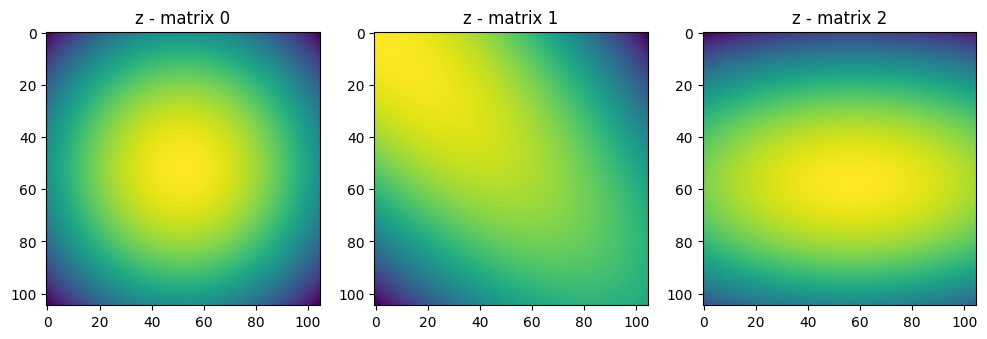

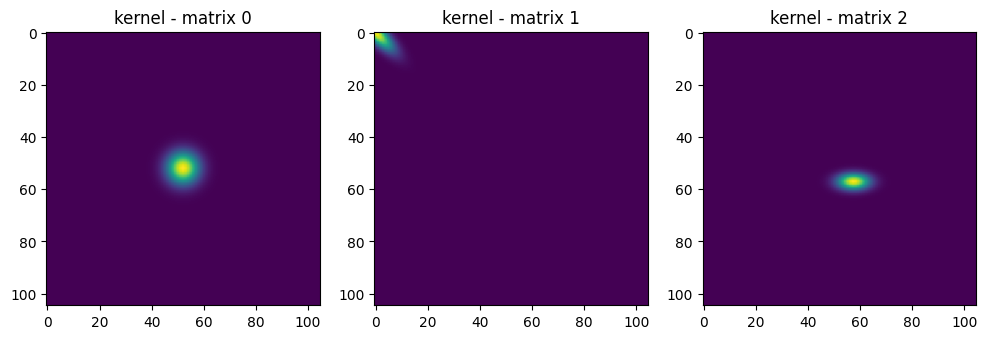

In [30]:
xy = xx.stack(yy, dim=-1)
# The xy matrix represents the coordinates of the image
# so that at each coordinate we have the x and y values
# which will take up some value based on the inverse of the 
# covariance matrix
# print("xy - matrix shape", xy.shape)

# print("xy - matrix") # is the x and y repeated kernel_size times
# print(xy.numpy())

# z is the standard Gaussian kernel with the given covariance matrix
z = Tensor.einsum('bxyi,bij,bxyj->bxy', xy, -0.5 * inv_covariance, xy)

fig, axes = plt.subplots(1, 3, figsize=(12, 6))  # Adjust figsize as needed
for i in range(3):
    axes[i].imshow(z.numpy()[i])
    axes[i].set_title(f"z - matrix {i}")

kernel = z.exp() / np.pi * covariance_det.sqrt().view(batch_size, 1, 1)
# print("kernel - matrix", kernel.numpy())
kernel_max = kernel.max(axis=(1,2), keepdim=True)
kernel_norm = kernel / kernel_max 

# show the 3 kernels
fig, axes = plt.subplots(1, 3, figsize=(12, 6))  # Adjust figsize as needed
for i in range(3):
    axes[i].imshow(kernel_norm.numpy()[i])
    axes[i].set_title(f"kernel - matrix {i}")


(3, 3, 105, 105)


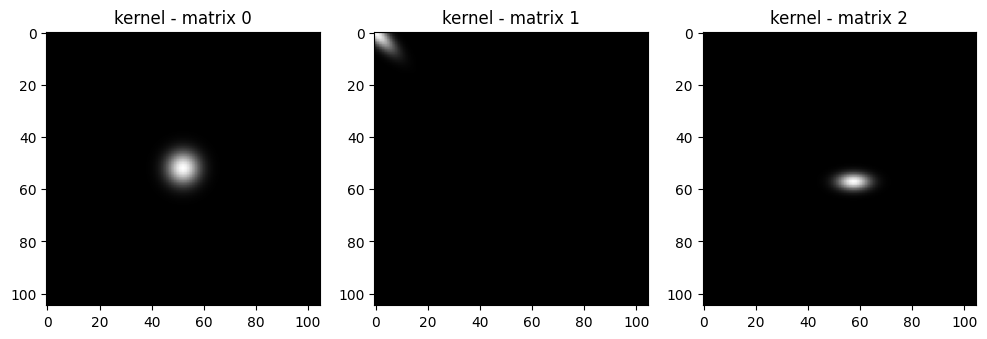

In [31]:
# now we are going into create the RGB space for the kernels
kernel_rgb = kernel_norm.unsqueeze(1).expand(-1, 3, -1, -1)
print(kernel_rgb.shape)
# show the 3 kernels
fig, axes = plt.subplots(1, 3, figsize=(12, 6))  # Adjust figsize as needed
for i in range(3):
    axes[i].imshow(kernel_rgb.numpy()[i].transpose(1,2,0))
    axes[i].set_title(f"kernel - matrix {i}")

Now we have 3 in this case, but n in the general case gaussian kernels. To each pixel will be associated a value for transparency or opacity. As you can not very well there are colors missing. Also we want to merge all these Gaussian kernels into a single image.

We will do the following in two steps as described below:

1. Multiply each kernel with the RGB value associated (initialized in the previous values)
2. sum the rgb Gaussians along each rgb channel to get the final colors and shapes

rgb_values_reshaped (3, 3, 1, 1)


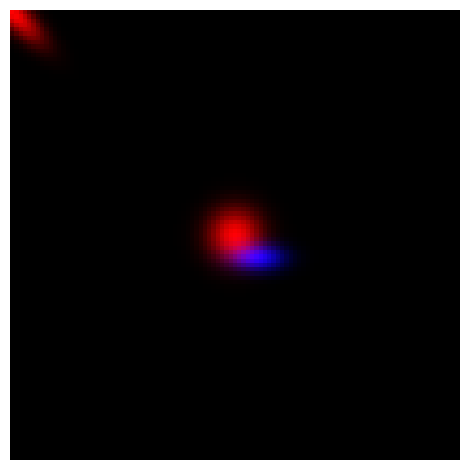

In [32]:
rgb_values_reshaped = colors.unsqueeze(1).unsqueeze(1).permute(0,3,1,2)
print("rgb_values_reshaped", rgb_values_reshaped.shape)

final_image_layers = rgb_values_reshaped * kernel_rgb
final_image = final_image_layers.sum(axis=0)
final_image = final_image.clamp(0, 1)
final_image = final_image.permute(1,2,0)

plt.imshow(final_image.numpy())
plt.axis("off")
plt.tight_layout()
plt.show()

Putting all together we will get a single function that given an input it will return the desired image.

In [33]:
def generate_splat(coordinates, colors, scale_x, scale_y, rotation, img_size):
    kernel_size = img_size[0]
        
    W = img_size[0] # width of the image
    H = img_size[1] # height of the image
    batch_size = colors.shape[0] # number of Gaussians defined above

    scale = scale_x.stack(scale_y, dim=1) # stack the two scales together
    scale = scale.reshape(batch_size, 2)
    rotation = rotation.reshape(batch_size)

    cos_rot = rotation.cos()
    sin_rot = rotation.sin()

    top = cos_rot.stack(-sin_rot, dim=1)
    bottom = sin_rot.stack(cos_rot, dim=1)
    R = top.stack(bottom, dim=2).reshape(batch_size, 2, 2)

    S = Tensor.eye(2).unsqueeze(0) * scale.unsqueeze(1)
    covariance = R @ S @ S @ R.transpose(-1,-2)

    inv_covariance, covariance_det = get_inverse_batched(covariance)

    x = np.linspace(-5, 5, kernel_size)
    y = np.linspace(-5, 5, kernel_size)
    yy, xx = Tensor(np.meshgrid(x, y))
    yy = yy.expand(batch_size, -1, -1)
    
    xx = xx.expand(batch_size, -1, -1)    

    xx = xx + coordinates[:,0].unsqueeze(1).unsqueeze(1) * 5
    yy = yy + coordinates[:,1].unsqueeze(1).unsqueeze(1) * 5

    xy = xx.stack(yy, dim=-1)
    z = Tensor.einsum('bxyi,bij,bxyj->bxy', xy, -0.5 * inv_covariance, xy)

    kernel = z.exp() / np.pi * covariance_det.sqrt().view(batch_size, 1, 1)
    kernel_max = kernel.max(axis=(1,2), keepdim=True) + 1e-6 # avoid division by zero
    kernel_norm = kernel / kernel_max 

    kernel_rgb = kernel_norm.unsqueeze(1).expand(-1, 3, -1, -1)
    rgb_values_reshaped = colors.unsqueeze(1).unsqueeze(1).permute(0,3,1,2)

    final_image_layers = rgb_values_reshaped * kernel_rgb    

    final_image = final_image_layers.sum(axis=0)

    final_image = final_image.clamp(0, 1)
    final_image = final_image.permute(1,2,0)

    return final_image

Testing the new function with new values will bring:

NOTE: converting from torch to tinygrad meant losing some out of the box function such as affine_grid, which required some advanced algorithms such as bilinear interpolation to work. I didn't have time and deep knowledge on how to make it work on tinygrad I directly skipped that step. On the other side that particular function was needed to learn the translation matrix for the Gaussian I had to make it learnable from some other place. 
As you might have noticed, I shifted the kernel directly when I was creating it. A problem of this is that the kernel has to already be the size of the image, which will alterate the meaning of mu and the covariance matrix, when the kernel dimensions change.
Therefore because of that you will see in the next cell, that the scale_x and scale_y values are downsized by the ration of img size and kernel.  

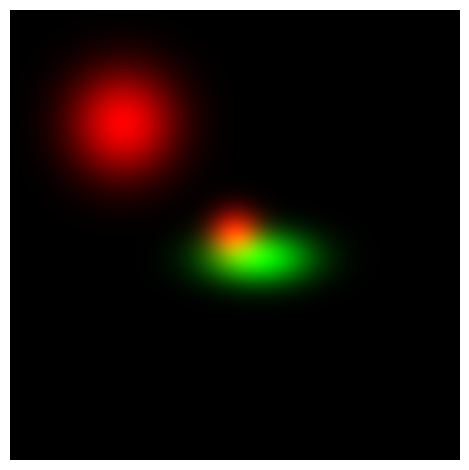

In [34]:
img_size = (256,256,3) # size of the image

kernel_size = 105 # dimension of the kernel -> it is the quality of the Gaussian
scale_x = Tensor([1.0,2.0,2.0]) # scale of the Gaussian in x direction
scale_y = Tensor([1.0,2.0,1.0]) # scale of the Gaussian in y direction
scale_x = scale_x / (img_size[0] / kernel_size)
scale_y = scale_y / (img_size[1] / kernel_size)
rotation = Tensor([0.0, 0.0, -(np.pi/2)]) # rotation of the Gaussian in radians
coordinates = Tensor([(0,0), (0.5,0.5), (-0.1, -0.1)]) # coordinates of the Gaussian
colors = Tensor([(1,0,0), (1,0,0), (0,1,0)]) # color of the Gaussian
W = img_size[0] # width of the image
H = img_size[1] # height of the image

splatted = generate_splat(coordinates, colors, scale_x, scale_y, rotation, img_size)

plt.imshow(splatted.numpy())
plt.axis("off")
plt.tight_layout()
plt.show()

In [35]:
def create_window(window_size, channel):

    def gaussian(window_size, sigma):
        gauss = Tensor([-(x - window_size//2)**2/float(2*sigma**2) for x in range(window_size)])
        gauss = gauss.exp()
        # print(gauss.numpy())
        return gauss / gauss.sum()
    
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    # print(_1D_window.numpy())

    _2D_window = _1D_window @ _1D_window.transpose(1,0)
    # print(_2D_window.numpy())

    window = _2D_window.unsqueeze(0).expand(channel, 1, window_size, window_size).contiguous()

    # print("WINDOW", window.numpy())
    # print(window.shape)
    return window

window = create_window(11, 3)

In [36]:
def ssim(img1, img2, window_size=11, size_average=True):

    (_,_,channel) = img1.shape

    img1 = img1.unsqueeze(0).permute(0,3,1,2)
    img2 = img2.unsqueeze(0).permute(0,3,1,2)

    #parameters for ssim --> https://en.wikipedia.org/wiki/Structural_similarity_index_measure
    C1 = 0.01**2
    C2 = 0.03**3

    window = create_window(window_size, channel)

    mux = (img1).conv2d(window, stride=1, padding=window_size//2, groups=channel)
    muy = (img2).conv2d(window, stride=1, padding=window_size//2, groups=channel)
    mu_x_sq = mux * mux
    mu_y_sq = muy * muy
    mu_xy = mux * muy

    sigma_x_sq = (img1 * img1).conv2d(window, stride=1, padding=window_size//2, groups=channel) - mu_x_sq
    sigma_y_sq = (img2 * img2).conv2d(window, stride=1, padding=window_size//2, groups=channel) - mu_y_sq
    sigma_xy = (img1 * img2).conv2d(window, stride=1, padding=window_size//2, groups=channel) - mu_xy

    SSIM_numerator = (2 * mu_xy + C1) * (2 * sigma_xy + C2)
    SSIM_denominator = (mu_x_sq + mu_y_sq + C1) * (sigma_x_sq + sigma_y_sq + C2)

    # print(SSIM_numerator.numpy())
    # print(SSIM_denominator.numpy())

    ssim_map = SSIM_numerator / SSIM_denominator

    # print(ssim_map.numpy())

    ret = ((1-ssim_map)/2).clamp(0, 1)  
    # print(ret.numpy())

    return ret

def d_ssim_loss(img1, img2, window_size=11, size_average=True):
    return ssim(img1, img2, window_size, size_average).mean()

def l1_loss(img1, img2):
    return (img1 - img2).abs().mean()

def combined_loss(img1, img2, lambda_param=0.84):   
    # print("l1_loss", l1_loss(img1, img2).numpy())
    # print("d_ssim_loss", d_ssim_loss(img1, img2).numpy()) 
    return (1 - lambda_param) * l1_loss(img1, img2) + lambda_param * d_ssim_loss(img1, img2)


In [45]:
KERNEL_SIZE = 101
image_size = [256, 256, 3]
primary_samples = 1000
backup_samples = 1000
num_epochs = 1001
densification_interval = 300
learning_rate = 0.01
image_file_name = "image.png"
display_interval = 100
gradient_threshold = 0.002
gaussian_threshold = 0.75
display_loss = True

In [46]:
from PIL import Image

num_samples = primary_samples + backup_samples
indices_tensor = Tensor([1,2,3,4], dtype=dtypes.int32)

image_path = image_file_name
original_image = Image.open(image_path)
original_image = original_image.resize((image_size[0],image_size[0]))
original_image = original_image.convert('RGB')
original_array = np.array(original_image)
original_array = original_array / 255.0
width, height, _ = original_array.shape

image_array = original_array

target_tensor = Tensor(image_array, dtype=dtypes.float32)

# Creating pixel values
coords_tensor = Tensor.rand(primary_samples, 2, dtype=dtypes.float32, requires_grad=True)
center_values = Tensor([0.5, 0.5], dtype=dtypes.float32, requires_grad=False)
coords_tensor = (coords_tensor - center_values) * 2
pixel_coords_tensor = coords_tensor.atanh()

# integer coordinates
coords_tensor_integers = (coords_tensor + 1) * 0.5 * image_size[0]
coords_tensor_integers = coords_tensor_integers.int()

# creating color values picked from the above pixels coordinates
color_values = image_array[coords_tensor_integers[:, 0].numpy(), coords_tensor_integers[:, 1].numpy()]
color_values_tensor = Tensor(color_values, dtype=dtypes.float32, requires_grad=True) - 1e-6
print(color_values_tensor[indices_tensor].numpy())
color_values_tensor = (color_values_tensor.div(1 - color_values_tensor)).log()

# randomly initialize the scales of the Gaussians
scale_values_tensor = Tensor.rand(primary_samples, 2, dtype=dtypes.float32, requires_grad=True)
scale_values_tensor = scale_values_tensor * (KERNEL_SIZE / image_size[0])
scale_values_tensor = (scale_values_tensor.div(1 - scale_values_tensor)).log()

# randomly initialize the alpha values
alpha_values_tensor = Tensor.rand(primary_samples, 1, dtype=dtypes.float32, requires_grad=True)
alpha_values_tensor = (alpha_values_tensor.div(1-alpha_values_tensor)).log()

# randomly initialize the rotation values
rotation_values_tensor = (2 * Tensor.rand(primary_samples, 1, dtype=dtypes.float32, requires_grad=True) - 1).atanh()

W_values = scale_values_tensor.cat(rotation_values_tensor, alpha_values_tensor, color_values_tensor, pixel_coords_tensor, dim=1)

current_marker = primary_samples

optimizer = Adam([W_values], lr=0.01)
loss_history = []


print("W_values", W_values.numpy())

[[0.999999   0.9843127  0.8980382 ]
 [0.8392147  0.65882254 0.53333235]
 [0.7843127  0.52156764 0.3607833 ]
 [0.41568527 0.21960685 0.13333234]]
W_values [[-0.54993796 -1.1160274   0.8613155  ...  1.1569787   0.58915764
   0.56054527]
 [-0.47431156 -1.4623814  -0.29018548 ...  2.1756144   0.5716399
   1.3245654 ]
 [-1.0486472  -0.44274005 -0.24903129 ...  0.13352737 -1.5464258
  -1.7472926 ]
 ...
 [-0.7139706  -0.72302985  0.58153236 ... -1.1786605  -0.5808338
   0.8099289 ]
 [-1.3315802  -0.7195469  -0.7180436  ...  0.91354233  1.2216995
  -1.3849137 ]
 [-2.0519974  -0.9536712   0.54569    ...  0.67554694  0.77612275
  -1.0774331 ]]


In [49]:
def step():
    output = W_values[:current_marker]    

    batch_size = output.shape[0]    
    scale = output[:,0:2].sigmoid()
    rotation = output[:,2].tanh() * np.pi /2
    alpha = output[:,3].sigmoid()
    color = output[:,4:7].sigmoid()
    coords = output[:,7:9].tanh()          

    colors_with_alpha = color * (alpha.view(batch_size, 1))

    g_tensor_batch = generate_splat(coords, colors_with_alpha, scale[:,0], scale[:,1], rotation, image_size)
    loss = combined_loss(g_tensor_batch, target_tensor, lambda_param=0.5)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    return loss, g_tensor_batch

jit_step = TinyJit(step)

In this first training we are also using TinyJIT() to JIT our code and make it faster. On my small benchmarks with JIT I got 40 seconds less time over 1000 iterations, just for free. It is my first experiment with Tinygrad and I will dig deeper in the next parts.

The goal of the next parts are:
1. Make the training faster and try to remove and optimize code
2. Make more benchmark with different amounts of Gaussians
3. Add one important step -> densification process.

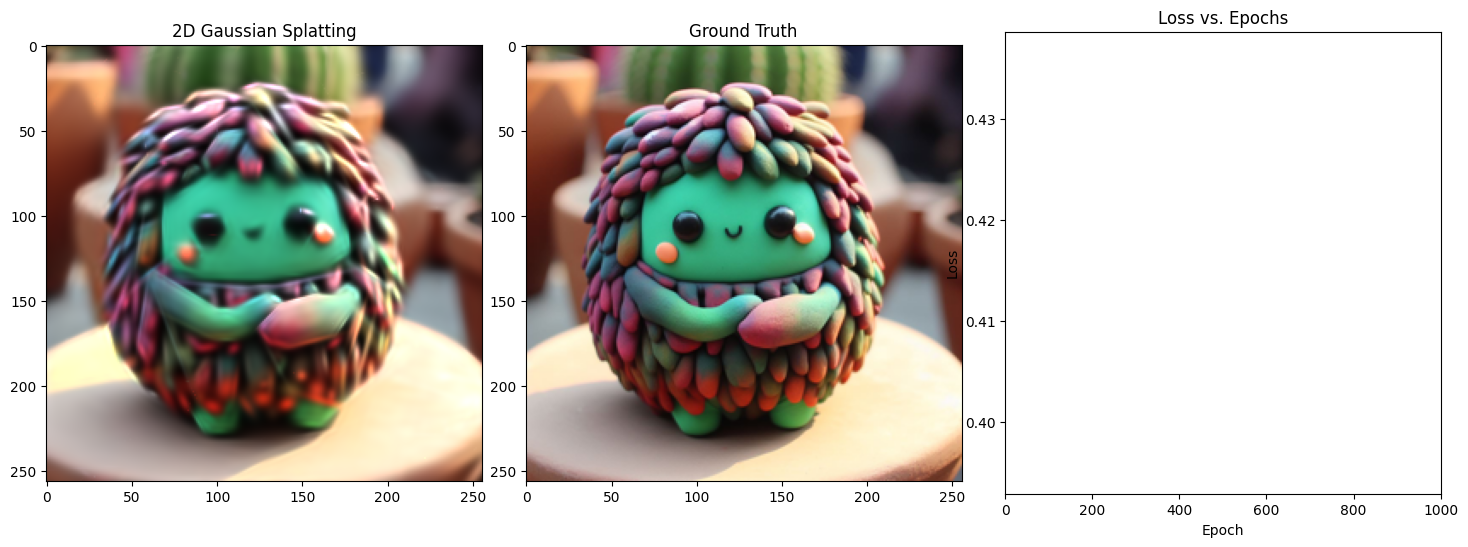

Epoch 1/1001, Loss: 0.0364842414855957, on 1000 points


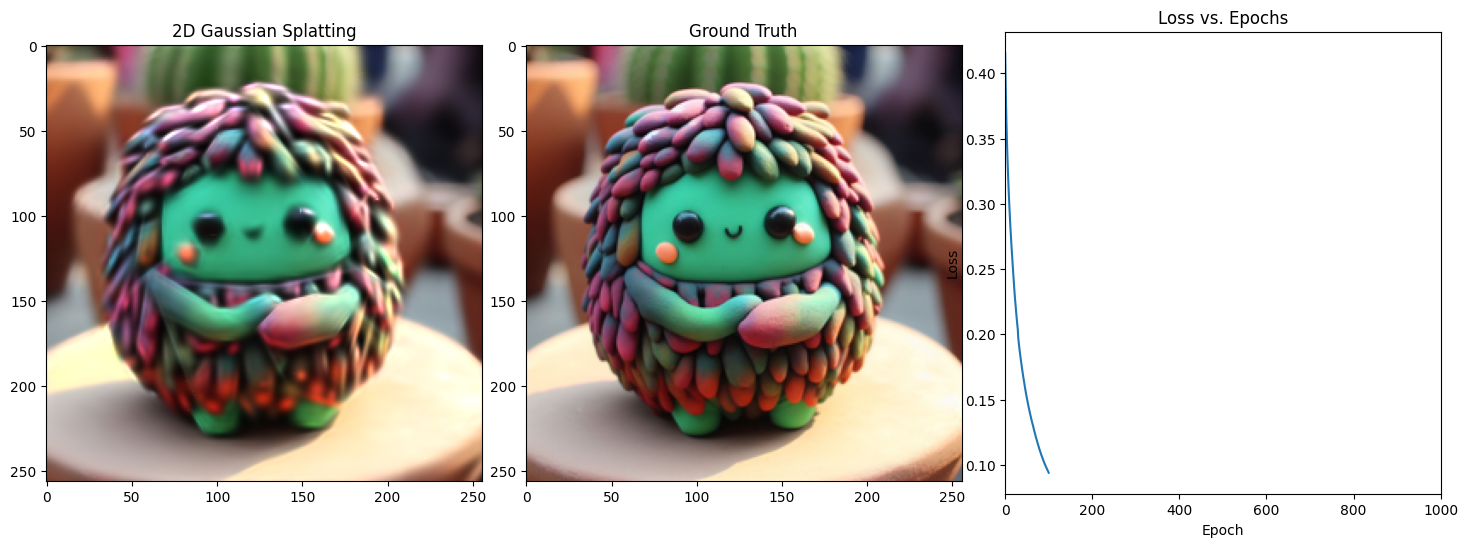

Epoch 101/1001, Loss: 0.03585021570324898, on 1000 points


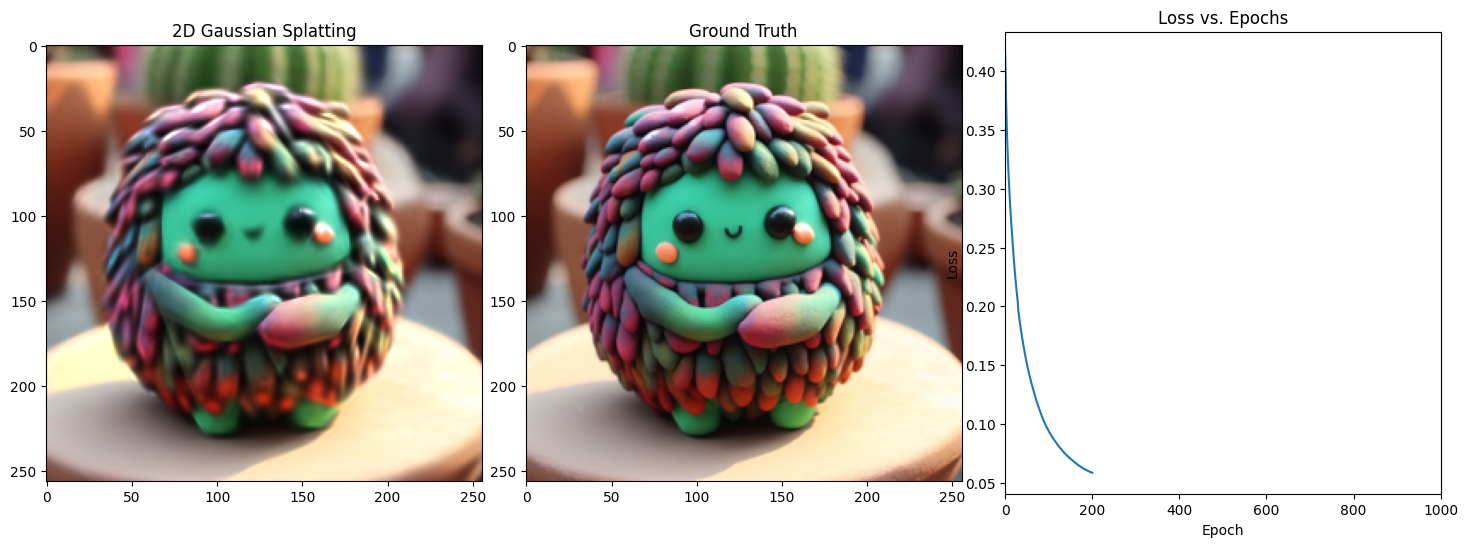

Epoch 201/1001, Loss: 0.03566993400454521, on 1000 points


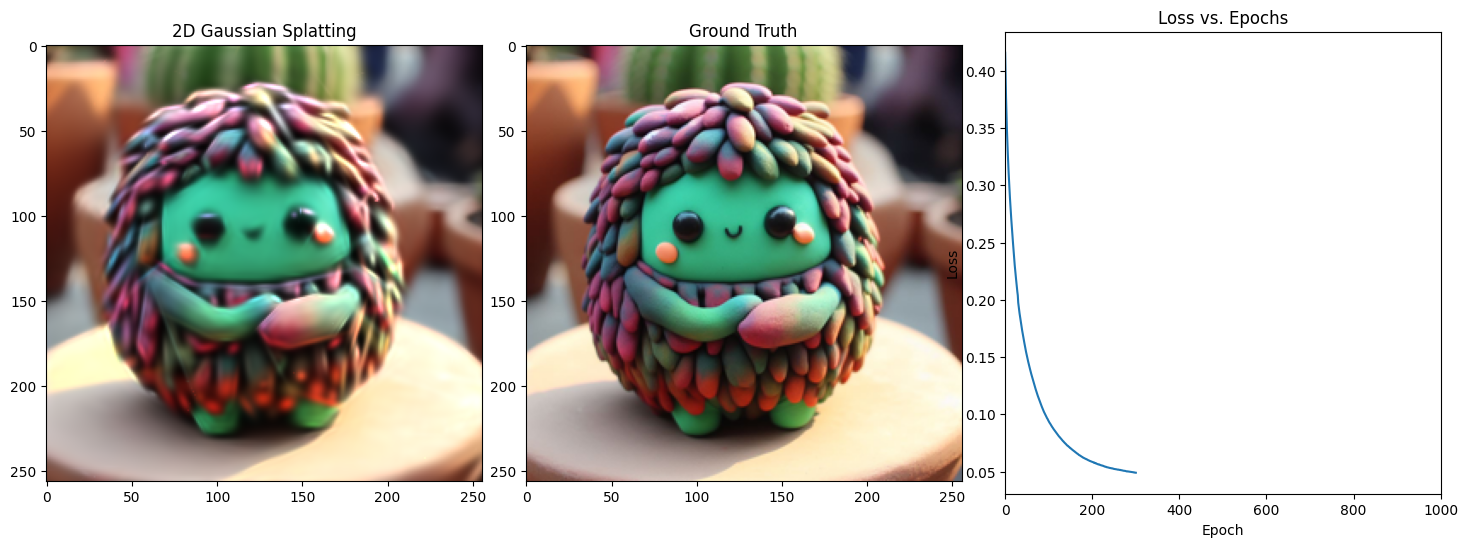

Epoch 301/1001, Loss: 0.034923359751701355, on 1000 points


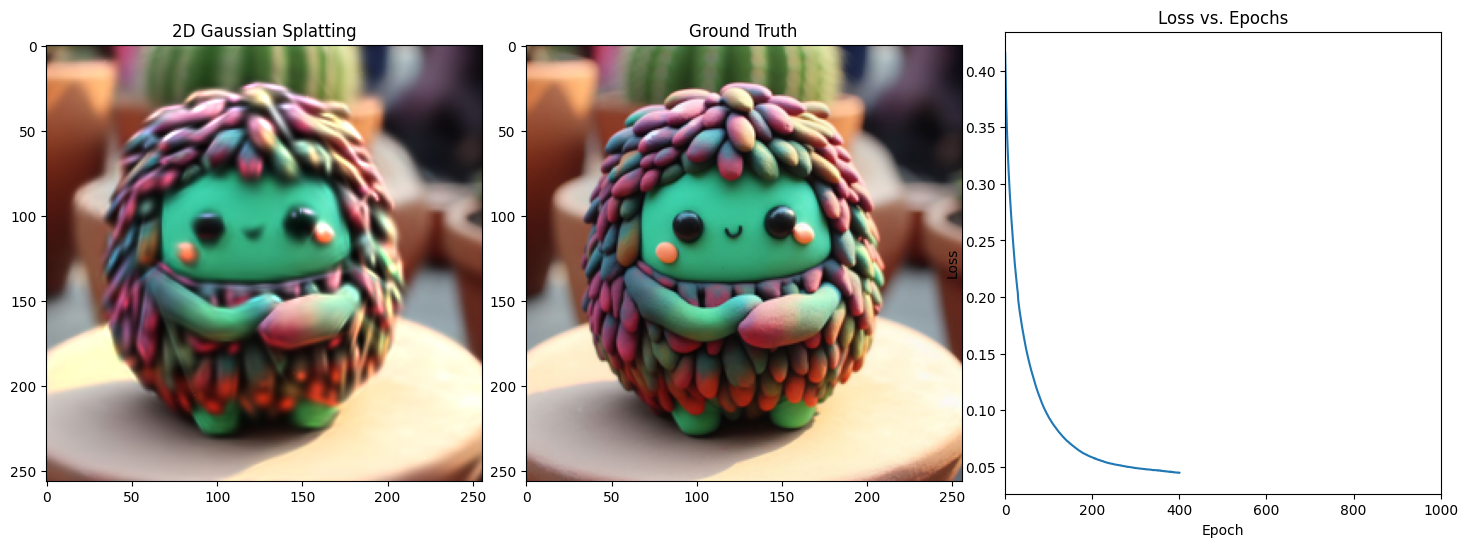

Epoch 401/1001, Loss: 0.034740205854177475, on 1000 points


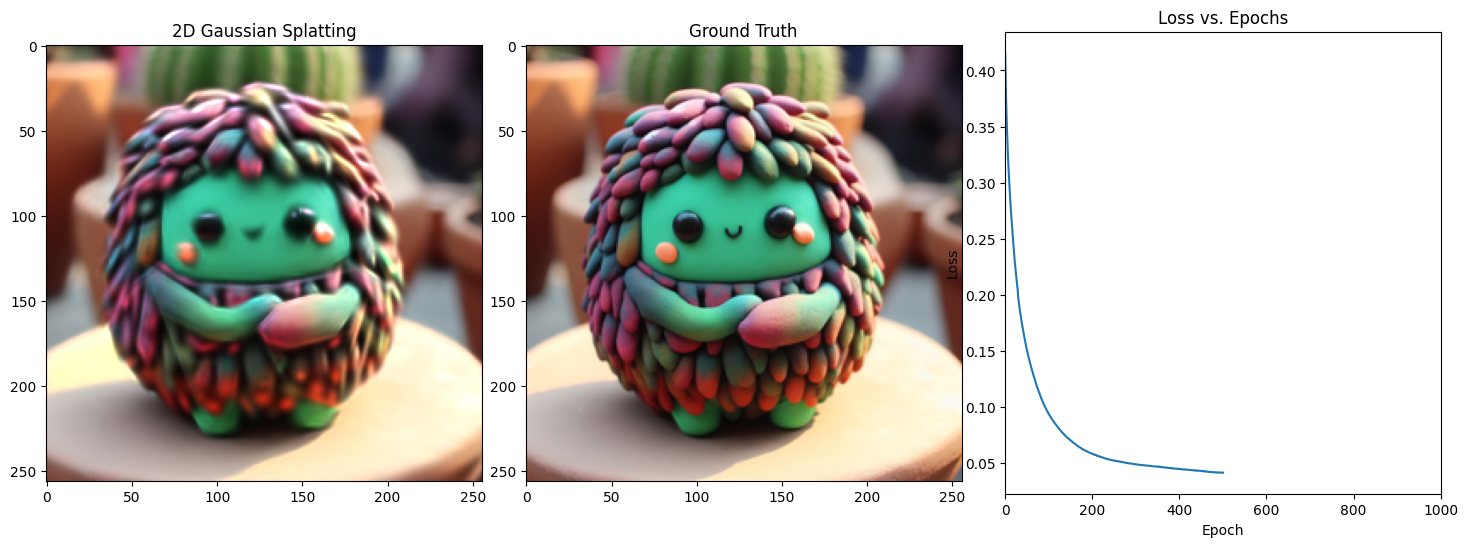

Epoch 501/1001, Loss: 0.034602079540491104, on 1000 points


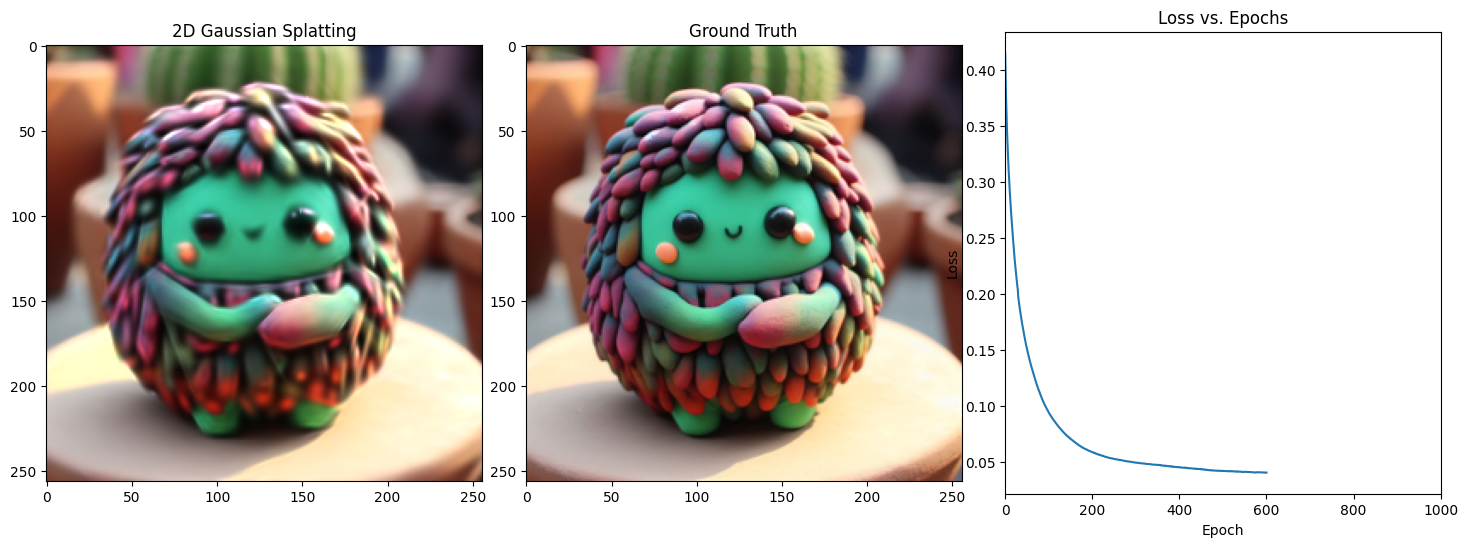

Epoch 601/1001, Loss: 0.034172043204307556, on 1000 points


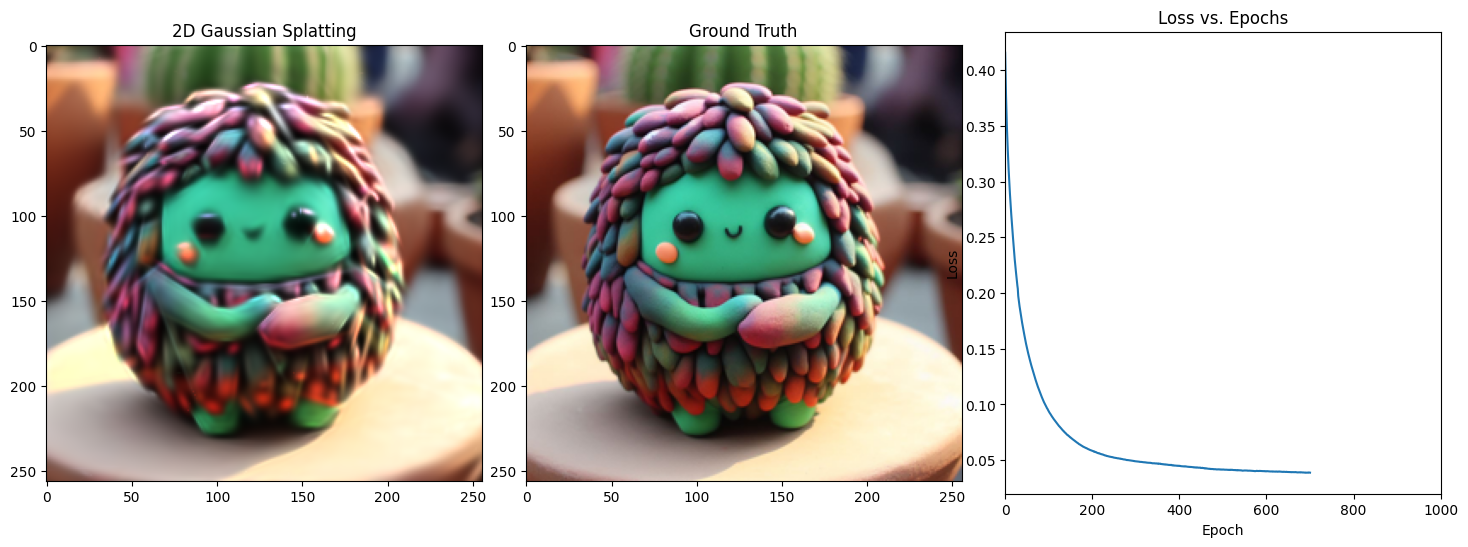

Epoch 701/1001, Loss: 0.03396090120077133, on 1000 points


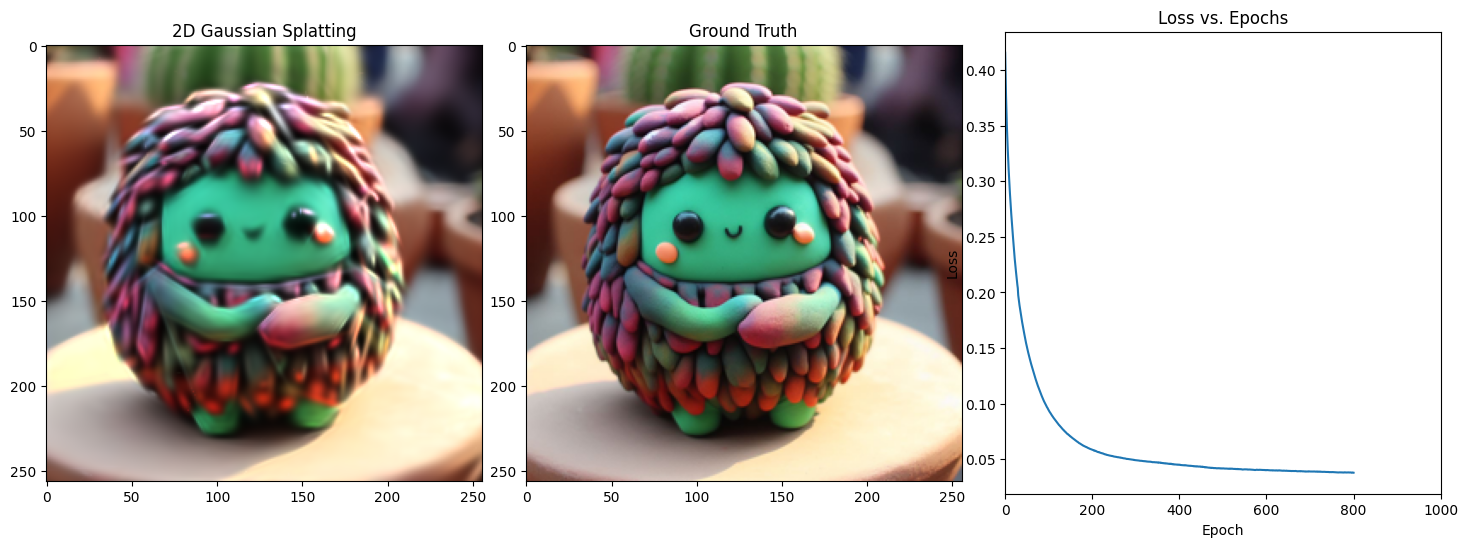

Epoch 801/1001, Loss: 0.0335845910012722, on 1000 points


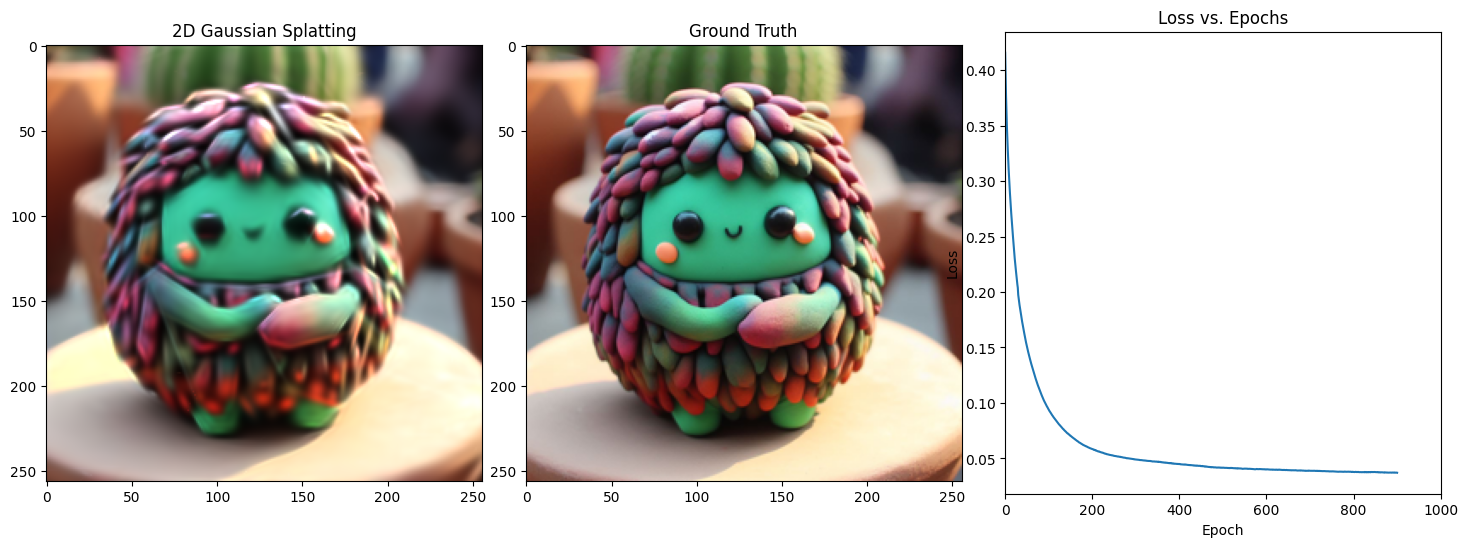

Epoch 901/1001, Loss: 0.03337327390909195, on 1000 points


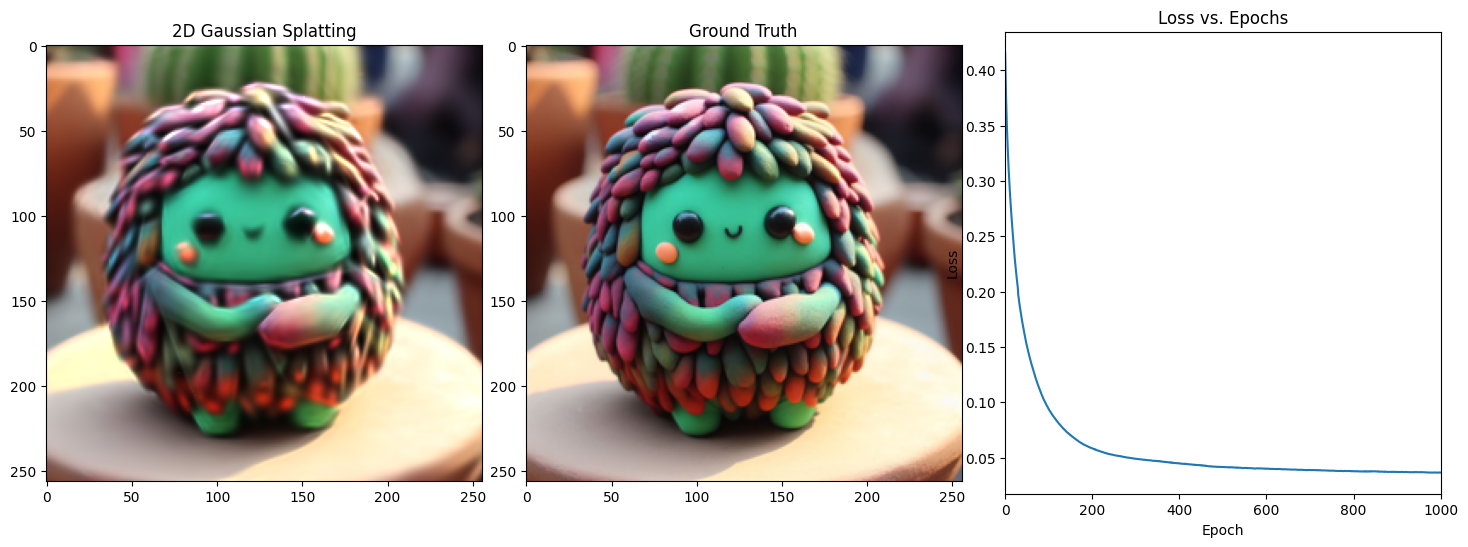

Epoch 1001/1001, Loss: 0.03339459002017975, on 1000 points


In [51]:
# 1.18 minutes 1000 epochs with MPS acceleration and TinyJIT enabled()

with Tensor.train():    

    for epoch in range(num_epochs):    

        loss, g_tensor_batch = jit_step()

        loss_history.append(loss.item())

        if epoch % display_interval == 0:
            num_subplots = 3 if display_loss else 2
            fig_size_width = 18 if display_loss else 12

            fig, ax = plt.subplots(1, num_subplots, figsize=(fig_size_width, 6))  # Adjust subplot to 1x3

            generated_array = g_tensor_batch.numpy()

            ax[0].imshow(g_tensor_batch.numpy())
            ax[0].set_title('2D Gaussian Splatting')
            # ax[0].axis('off')

            ax[1].imshow(target_tensor.numpy())
            ax[1].set_title('Ground Truth')
            # ax[1].axis('off')

            if display_loss:
                ax[2].plot(range(epoch + 1), loss_history[:epoch + 1])
                ax[2].set_title('Loss vs. Epochs')
                ax[2].set_xlabel('Epoch')
                ax[2].set_ylabel('Loss')
                ax[2].set_xlim(0, num_epochs)  # Set x-axis limits

            # Display the image
            #plt.show(block=False)
            plt.subplots_adjust(wspace=0.1)  # Adjust this value to your preference
            plt.pause(0.1)  # Brief pause

            img = Image.fromarray((generated_array * 255).astype(np.uint8))            

            plt.clf()  # Clear the current figure
            plt.close()  # Close the current figure

            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, on {len(W_values[:current_marker])} points") 

In [ ]:
# 1.58 minutes for 1000 epochs MPS accelerated

with Tensor.train():    

    for epoch in range(num_epochs):

        output = W_values                                  

        batch_size = output.shape[0]
        scale = output[:,0:2].sigmoid()
        rotation = output[:,2].tanh() * np.pi /2
        alpha = output[:,3].sigmoid()
        color = output[:,4:7].sigmoid()        
        coords = output[:,7:9].tanh()          

        colors_with_alpha = color * (alpha.view(batch_size, 1))     

        # I think I just need to change the order here! and then it should magically work         

        g_tensor_batch = generate_splat(coords, colors_with_alpha, scale[:,0], scale[:,1], rotation, image_size)        
        loss = combined_loss(g_tensor_batch, target_tensor, lambda_param=0.5)        

        optimizer.zero_grad()        

        loss.backward()

        optimizer.step()

        loss_history.append(loss.item())

        if epoch % display_interval == 0:
            num_subplots = 3 if display_loss else 2
            fig_size_width = 18 if display_loss else 12

            fig, ax = plt.subplots(1, num_subplots, figsize=(fig_size_width, 6))  # Adjust subplot to 1x3

            generated_array = g_tensor_batch.numpy()

            ax[0].imshow(g_tensor_batch.numpy())
            ax[0].set_title('2D Gaussian Splatting')
            # ax[0].axis('off')

            ax[1].imshow(target_tensor.numpy())
            ax[1].set_title('Ground Truth')
            # ax[1].axis('off')

            if display_loss:
                ax[2].plot(range(epoch + 1), loss_history[:epoch + 1])
                ax[2].set_title('Loss vs. Epochs')
                ax[2].set_xlabel('Epoch')
                ax[2].set_ylabel('Loss')
                ax[2].set_xlim(0, num_epochs)  # Set x-axis limits

            # Display the image
            #plt.show(block=False)
            plt.subplots_adjust(wspace=0.1)  # Adjust this value to your preference
            plt.pause(0.1)  # Brief pause

            img = Image.fromarray((generated_array * 255).astype(np.uint8))            

            plt.clf()  # Clear the current figure
            plt.close()  # Close the current figure

            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, on {len(output)} points") 